<a href="https://colab.research.google.com/github/Farah-Saleem91/adult-income-analysis/blob/main/Deep_Learning_Adult_income_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ============================
# Essential Imports for Analysis
# ============================

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# Classic Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# ML Evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Handling Imbalance
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
#Keras
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout

# Miscellaneous
import warnings
warnings.filterwarnings('ignore')


In [ ]:
def plot_history(history, figsize=(6,12), marker='o'):

    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]

    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)

    # For each metric
    for i, metric_name in enumerate(metrics):

        # Get the axis for the current metric
        ax = axes[i]

        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch

        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)

        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)

        # Final subplot adjustments
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

In [21]:
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [ ]:
#find duplicates
df.duplicated().sum()
#drop duplicates
df=df.drop_duplicates()
#drop fnlwgt
df=df.drop(columns=['fnlwgt'])

In [ ]:
#replace ? with missing
df=df.replace('?','missing')

In [ ]:
#feature engineering
#merege caplital gain and capitla loss into one column
#combine capital gain and capital loss columns
df['capital']=df['capital-gain']-df['capital-loss']
df['capital']
#drop capital gain and capital loss
df=df.drop(columns=['capital-gain','capital-loss'])


In [11]:
df['income'].value_counts(normalize=True)

,proportion
income,
<=50K,0.760586
>50K,0.239414


In [12]:
#change lables on income (the target)
df['income']=df['income'].replace({'<=50K':0,'>50K':1})
df['income'].value_counts(normalize=True)

,proportion
income,
0,0.760586
1,0.239414


In [14]:
X = df.drop(columns='income')
y=df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify= y , random_state=42)

In [15]:
#creat numerical tuple
num_cols = X_train.select_dtypes('number').columns

num_scaler = StandardScaler()
num_pipe = make_pipeline( num_scaler)
num_tuple = ('numaric', num_pipe, num_cols)
num_tuple
#create object tuple
ohe_cols = X_train.select_dtypes('object').columns
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe_pipe = make_pipeline(ohe_encoder)
ohe_pipe
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)
ohe_tuple
#Creat prerocessor
preprocessor = ColumnTransformer(transformers=[num_tuple, ohe_tuple],
                                 verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('numaric',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 Index(['age', 'educational-num', 'hours-per-week', 'capital'], dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [16]:
x_train_processed = preprocessor.fit_transform(X_train)
x_test_processed = preprocessor.transform(X_test)

In [17]:
#find input shape
input_shape= x_train_processed.shape
input_shape

(36592, 106)

In [18]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout

# create and compile the model
model = keras.Sequential()
model.add(Dense(64, input_dim=106,
          activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

# Compile Model
model.compile(loss = 'bce', optimizer = 'adam',
metrics=['accuracy', metrics.Precision(),
metrics.Recall()])


In [19]:
history = model.fit(x_train_processed, y_train,
validation_split = .2,
epochs=100,
verbose=0, )

(<Figure size 600x1200 with 4 Axes>,
 array([<Axes: title={'center': 'accuracy'}>,
        <Axes: title={'center': 'loss'}>,
        <Axes: title={'center': 'precision'}>,
        <Axes: title={'center': 'recall'}>], dtype=object))

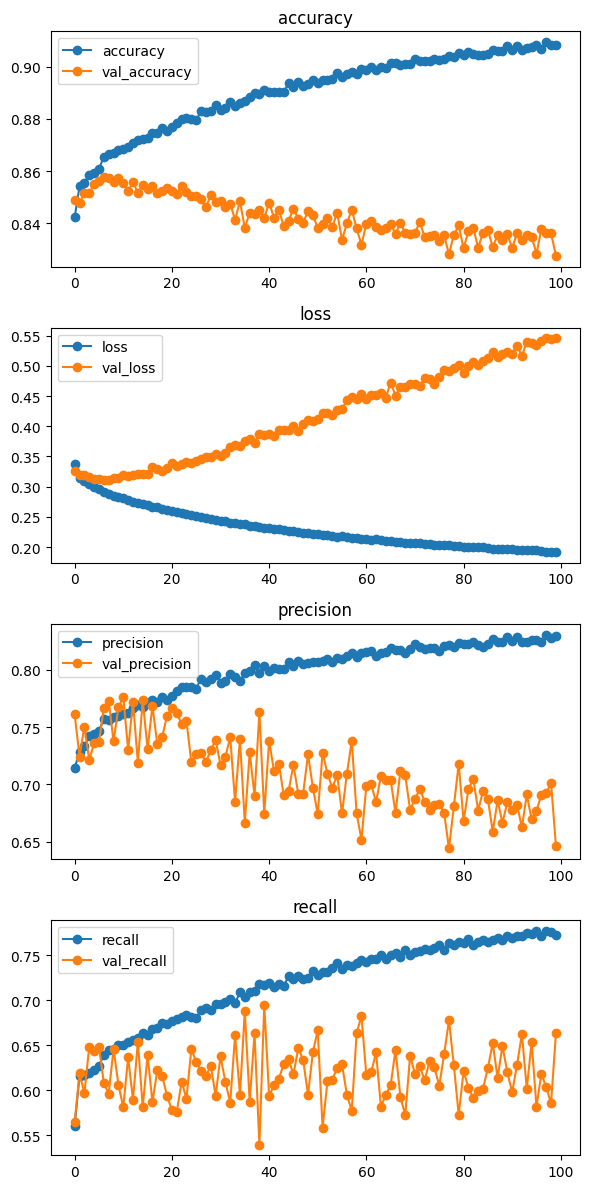

In [20]:
plot_history(history)

1144/1144 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
--- Training Data Evaluation ---
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     27831
           1       0.77      0.79      0.78      8761

    accuracy                           0.89     36592
   macro avg       0.85      0.86      0.86     36592
weighted avg       0.90      0.89      0.89     36592



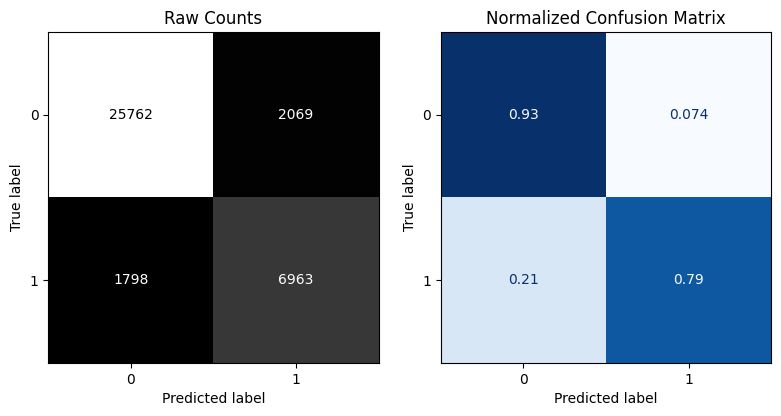


--- Test Data Evaluation ---
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      9278
           1       0.63      0.64      0.64      2920

    accuracy                           0.82     12198
   macro avg       0.76      0.76      0.76     12198
weighted avg       0.83      0.82      0.82     12198



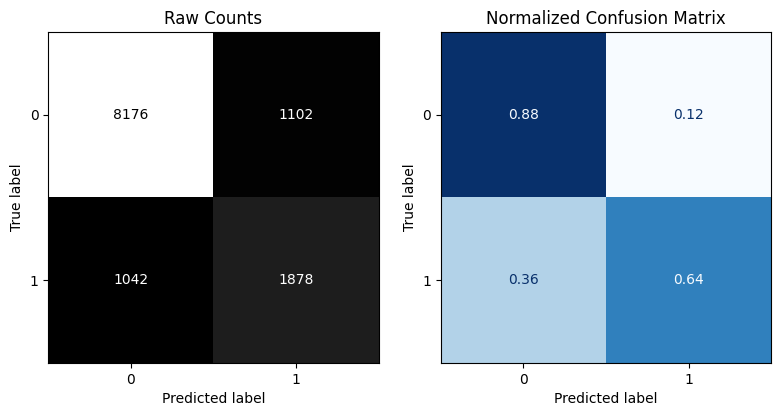

In [26]:
# Get predictions from the model (these are probabilities)
y_train_pred_proba = model.predict(x_train_processed)
y_test_pred_proba = model.predict(x_test_processed)

# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
y_train_pred = (y_train_pred_proba > 0.5).astype(int)
y_test_pred = (y_test_pred_proba > 0.5).astype(int)

# Now call the classification_metrics function directly for train and test
print("--- Training Data Evaluation ---")
classification_metrics(y_train, y_train_pred, label='Training Data')

print("\n--- Test Data Evaluation ---")
classification_metrics(y_test, y_test_pred, label='Test Data')